In [ ]:
# ERROR CORRECTION 
import cirq
import ipywidgets as widgets
from IPython.display import display, clear_output
import random

# ----- Widget Setup -----
# Slider to choose the number of qubits (from 1 to 10)
num_qubits_slider = widgets.IntSlider(
    min=1, max=10, value=3, description="Num Qubits:"
)

# Multi-select widget for applying errors to selected qubits.
# Its options will be updated based on the number of qubits.
error_selector = widgets.SelectMultiple(
    options=[('Qubit 0', 0), ('Qubit 1', 1), ('Qubit 2', 2)],
    value=[],
    description='Error on:'
)

# Dropdown to select the error correction scheme.
# "Bit-flip" uses X errors; "Phase-flip" uses Z errors (with basis change).
scheme_selector = widgets.Dropdown(
    options=[('Bit-flip Error Correction', 'bit-flip'),
             ('Phase-flip Error Correction', 'phase-flip')],
    value='bit-flip',
    description="Scheme:"
)

# When the number of qubits changes, update the error_selector options.
def update_error_options(change):
    n = change['new']
    options = [(f"Qubit {i}", i) for i in range(n)]
    error_selector.options = options
    error_selector.value = ()  # Clear any previous selection

num_qubits_slider.observe(update_error_options, names='value')

# Button to run a round of the simulation.
run_button = widgets.Button(
    description="Run Round",
    button_style='info'
)

# Output area to display messages and results.
output_area = widgets.Output()

# ----- Simulation Function -----
def run_round(b):
    with output_area:
        clear_output()  # Clear previous round's output.
        n = num_qubits_slider.value
        scheme = scheme_selector.value  # Either "bit-flip" or "phase-flip"
        
        # Create n qubits.
        qubits = [cirq.LineQubit(i) for i in range(n)]
        
        # Step 1: Randomly choose a secret encoded logical bit (0 or 1).
        secret = random.choice([0, 1])
        print(f"Secret encoded logical bit: {secret}")
        print(f"Encoding state: All {n} qubits will be prepared in state {secret}.")
        
        # Step 2: Build the circuit to encode the secret.
        circuit = cirq.Circuit()
        if secret == 1:
            # For secret 1, apply an X gate to qubit 0.
            circuit.append(cirq.X(qubits[0]))
            print("Applied X gate on qubit 0 to encode logical 1.")
        else:
            print("No X gate applied; qubit 0 remains in state |0> for logical 0.")
        
        # Encode the logical qubit across all qubits using CNOT gates.
        if n > 1:
            for i in range(1, n):
                circuit.append(cirq.CNOT(qubits[0], qubits[i]))
            print("Encoded the logical qubit into all qubits using CNOT gates.")
        else:
            print("Only one qubit used; no encoding via CNOT gates needed.")
        
        # For Phase-flip error correction, convert to the Hadamard basis.
        if scheme == 'phase-flip':
            circuit.append([cirq.H(q) for q in qubits])
            print("\n[Phase-flip] Converted to Hadamard basis (applied H to all qubits).")
        
        # Step 3: Error Injection by the user.
        errors = list(error_selector.value)
        if errors:
            if scheme == 'bit-flip':
                # For bit-flip, inject X errors.
                for idx in errors:
                    circuit.append(cirq.X(qubits[idx]))
                print(f"\n[Bit-flip] Applied X error on qubit(s): {errors}")
            elif scheme == 'phase-flip':
                # For phase-flip, inject Z errors.
                for idx in errors:
                    circuit.append(cirq.Z(qubits[idx]))
                print(f"\n[Phase-flip] Applied Z error on qubit(s): {errors}")
        else:
            print("\nNo errors applied.")
        
        # For Phase-flip error correction, convert back to the computational basis.
        if scheme == 'phase-flip':
            circuit.append([cirq.H(q) for q in qubits])
            print("Converted back to computational basis (applied H to all qubits).")
        
        # Step 4: Measurement (simulating syndrome extraction).
        circuit.append(cirq.measure(*qubits, key='result'))
        print("\nFinal Circuit:")
        print(circuit)
        
        # Run the circuit (single shot).
        simulator = cirq.Simulator()
        result = simulator.run(circuit, repetitions=1)
        meas = result.measurements['result'][0]
        print("\nMeasurement result (raw output from each qubit):", meas)
        
        # Step 5: Error Detection & Correction via Majority Vote.
        sum_meas = sum(meas)
        if n % 2 == 0 and sum_meas == n // 2:
            print("\nTie in measurement (equal number of 0's and 1's).")
            print("Error correction ambiguous: unable to determine the correct state.")
            corrected_state = None
        else:
            majority = 1 if sum_meas > n/2 else 0
            corrected_state = majority
            print("\nMajority vote (decoded logical bit):", majority)
            
            error_locations = [i for i, bit in enumerate(meas) if bit != majority]
            print("Detected errors on qubit(s):", error_locations)
            
            corrected_meas = meas.copy()
            for i in error_locations:
                corrected_meas[i] = majority
            print("Measurement result after applying corrections:", corrected_meas)
        
        # Step 6: Outcome Comparison.
        if corrected_state is not None:
            if corrected_state == secret:
                print("\nError correction successful: The logical state was restored correctly!")
            else:
                print("\nError correction failed: The logical state is flipped relative to the secret!")
        else:
            print("\nDue to the tie, error correction could not be performed.")
            
# Connect the button to the simulation function.
run_button.on_click(run_round)

# Display all widgets.
display(num_qubits_slider, error_selector, scheme_selector, run_button, output_area)

In [ ]:
# Fault Tolerance

import cirq
import ipywidgets as widgets
from IPython.display import display, clear_output
import random

# ----- Widget Setup -----
# Slider to choose the number of qubits (from 1 to 10)
num_qubits_slider = widgets.IntSlider(
    min=1, max=10, value=3, description="Num Qubits:"
)

# Multi-select widget for applying errors to selected qubits.
error_selector = widgets.SelectMultiple(
    options=[('Qubit 0', 0), ('Qubit 1', 1), ('Qubit 2', 2)],
    value=[],
    description='Error on:'
)

# Dropdown to select the protocol: Non Fault Tolerant or Fault Tolerant
protocol_selector = widgets.Dropdown(
    options=[('Non Fault Tolerant', 'non_ft'),
             ('Fault Tolerant (with repeated syndrome extraction)', 'ft')],
    value='non_ft',
    description='Protocol:'
)

# Slider for syndrome rounds (only relevant if Fault Tolerant is selected)
syndrome_rounds_slider = widgets.IntSlider(
    min=1, max=5, value=3, description="Syndrome Rounds:"
)

# Slider for measurement error probability (simulating noise during syndrome extraction)
measurement_error_slider = widgets.FloatSlider(
    min=0.0, max=0.5, step=0.01, value=0.0, description="Meas. Error Prob:"
)

# Update error_selector options when the number of qubits changes.
def update_error_options(change):
    n = change['new']
    options = [(f"Qubit {i}", i) for i in range(n)]
    error_selector.options = options
    error_selector.value = ()  # Clear any previous selection

num_qubits_slider.observe(update_error_options, names='value')

# Button to run a simulation round.
run_button = widgets.Button(
    description="Run Round",
    button_style='info'
)

# Output area to display messages and results.
output_area = widgets.Output()

# Container for all widgets.
widgets_box = widgets.VBox([num_qubits_slider, error_selector, protocol_selector,
                            syndrome_rounds_slider, measurement_error_slider, run_button, output_area])

# ----- Simulation Function -----
def run_round(b):
    with output_area:
        clear_output()  # Clear previous output.
        n = num_qubits_slider.value
        protocol = protocol_selector.value  # 'non_ft' or 'ft'
        syndrome_rounds = syndrome_rounds_slider.value
        meas_error_prob = measurement_error_slider.value
        
        # Create n qubits.
        qubits = [cirq.LineQubit(i) for i in range(n)]
        
        # Step 1: Randomly choose a secret encoded logical bit (0 or 1).
        secret = random.choice([0, 1])
        print(f"Secret encoded logical bit: {secret}")
        print(f"Encoding state: All {n} qubits will be prepared in state {secret}.")
        
        # Step 2: Build the circuit to encode the secret using a repetition code.
        circuit = cirq.Circuit()
        if secret == 1:
            # For secret 1, apply an X gate to qubit 0.
            circuit.append(cirq.X(qubits[0]))
            print("Applied X gate on qubit 0 to encode logical 1.")
        else:
            print("No X gate applied; qubit 0 remains in |0> for logical 0.")
            
        # Distribute the state to all qubits via CNOT gates.
        if n > 1:
            for i in range(1, n):
                circuit.append(cirq.CNOT(qubits[0], qubits[i]))
            print("Encoded the logical qubit into all qubits using CNOT gates.")
        else:
            print("Only one qubit used; no encoding via CNOT gates needed.")
        
        # Step 3: Error Injection by the user.
        errors = list(error_selector.value)
        if errors:
            for idx in errors:
                circuit.append(cirq.X(qubits[idx]))
            print(f"\nApplied X error on qubit(s): {errors}")
        else:
            print("\nNo user-injected errors applied.")
        
        # Step 4: Measurement – add measurement to all qubits.
        circuit.append(cirq.measure(*qubits, key='result'))
        print("\nFinal Circuit:")
        print(circuit)
        
        # Run the circuit ideally (without measurement noise).
        simulator = cirq.Simulator()
        result = simulator.run(circuit, repetitions=1)
        ideal_meas = result.measurements['result'][0]
        print("\nIdeal Measurement result (raw from circuit):", ideal_meas)
        
        # Step 5: Syndrome Extraction & Fault Tolerance.
        if protocol == 'non_ft':
            # Non Fault Tolerant: Use the ideal measurement result directly.
            final_meas = ideal_meas
            print("\nProtocol: Non Fault Tolerant (single measurement).")
        else:
            # Fault Tolerant: Simulate repeated syndrome extraction with noisy measurements.
            print(f"\nProtocol: Fault Tolerant with {syndrome_rounds} syndrome rounds")
            rounds_results = []
            for r in range(syndrome_rounds):
                noisy_round = []
                for bit in ideal_meas:
                    # With probability 'meas_error_prob', flip the bit.
                    if random.random() < meas_error_prob:
                        noisy_round.append(1 - bit)
                    else:
                        noisy_round.append(bit)
                rounds_results.append(noisy_round)
                print(f"Round {r+1} measurement (with noise): {noisy_round}")
            # For each qubit, take a majority vote over the syndrome rounds.
            final_meas = []
            for q in range(n):
                bits = [rounds_results[r][q] for r in range(syndrome_rounds)]
                majority_bit = 1 if sum(bits) > syndrome_rounds/2 else 0
                final_meas.append(majority_bit)
            print("\nFinal measurement after majority vote over syndrome rounds:", final_meas)
        
        # Step 6: Error Detection & Correction via Majority Vote.
        sum_meas = sum(final_meas)
        if n % 2 == 0 and sum_meas == n // 2:
            print("\nTie in measurement (equal number of 0's and 1's).")
            print("Error correction ambiguous: unable to determine the correct state.")
            corrected_state = None
        else:
            majority_vote = 1 if sum_meas > n/2 else 0
            corrected_state = majority_vote
            print("\nMajority vote (decoded logical bit):", majority_vote)
            
            error_locations = [i for i, bit in enumerate(final_meas) if bit != majority_vote]
            print("Detected errors on qubit(s):", error_locations)
            
            corrected_meas = final_meas.copy()
            for i in error_locations:
                corrected_meas[i] = majority_vote
            print("Measurement result after applying corrections:", corrected_meas)
        
        # Step 7: Outcome.
        if corrected_state is not None:
            if corrected_state == secret:
                print("\nFault tolerance successful: The logical state was restored correctly!")
            else:
                print("\nFault tolerance failed: The logical state is flipped relative to the secret!")
        else:
            print("\nDue to a tie, error correction could not be performed.")

# Connect the run button to the simulation function.
run_button.on_click(run_round)

# Display all widgets.
display(widgets_box)


🔦 Treasure hidden at location 52 (row 6, col 4)

🔍 Classical search in progress...


RuntimeError: Requested MovieWriter (ffmpeg) not available

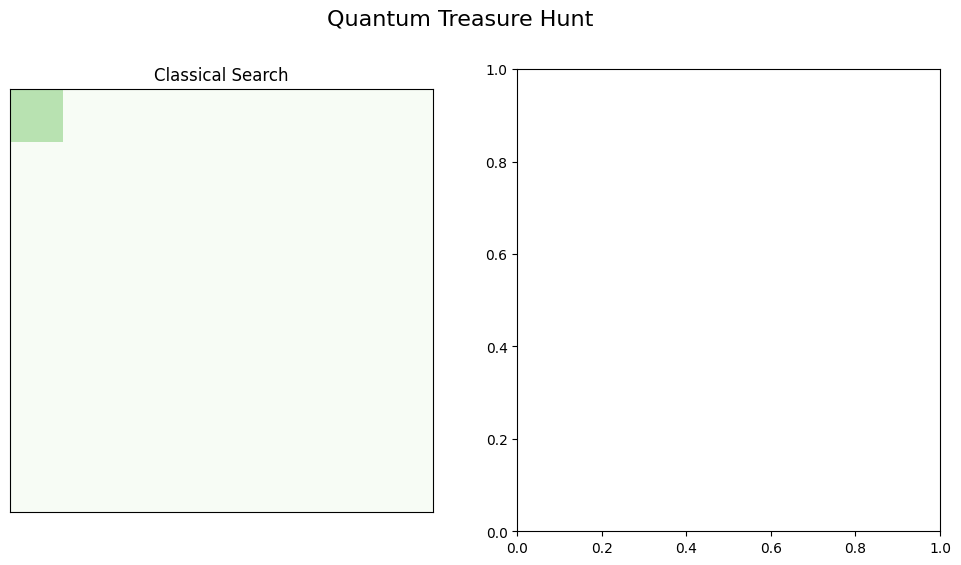

In [3]:

import cirq
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display, clear_output

def main():
    # Get user input for difficulty level
    difficulty = input("Choose difficulty (easy/medium/hard): ").lower()
    size_dict = {'easy': 2, 'medium': 4, 'hard': 8}
    grid_size = size_dict.get(difficulty, 2)
    n_qubits = int(np.log2(grid_size**2)) if grid_size > 2 else 2

    # Generate treasure location
    N = grid_size**2
    target = np.random.randint(N)
    print(f"\n🔦 Treasure hidden at location {target} (row {target//grid_size}, col {target%grid_size})")

    # Set up figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle("Quantum Treasure Hunt", fontsize=16)

    # Classical Search Animation
    def animate_classical():
        ax1.set_title("Classical Search")
        ax1.set_xticks([])
        ax1.set_yticks([])
        grid = np.zeros((grid_size, grid_size))
        im = ax1.imshow(grid, vmin=0, vmax=1, cmap='Greens')
        text = ax1.text(0, 0, "", ha='center', va='center', fontsize=16)

        def update(frame):
            nonlocal grid
            grid.flat[frame] = 0.3  # Mark searched
            if frame == target:
                grid.flat[frame] = 1.0  # Highlight treasure
                text.set_text("🎉")
                text.set_position((frame%grid_size, frame//grid_size))
            im.set_data(grid)
            return im, text

        anim = animation.FuncAnimation(fig, update, frames=N, interval=500, blit=True)
        return HTML(anim.to_html5_video())

    # Quantum Search Setup
    qubits = cirq.LineQubit.range(n_qubits)
    iterations = int(np.pi/4 * np.sqrt(N))  # Grover iterations
    
    # Build oracle (fixed multi-controlled Z)
    target_bin = format(target, f'0{n_qubits}b')
    oracle = cirq.Circuit()
    # Flip qubits to match target state
    for q, bit in zip(reversed(qubits), target_bin):
        if bit == '0':
            oracle.append(cirq.X(q))
    # Apply multi-controlled Z
    oracle.append(cirq.Z(qubits[-1]).controlled_by(*qubits[:-1]))
    # Flip qubits back
    for q, bit in zip(reversed(qubits), target_bin):
        if bit == '0':
            oracle.append(cirq.X(q))

    # Build Grover iteration (fixed diffusion operator)
    def grover_iteration():
        yield oracle
        yield cirq.H.on_each(qubits)
        yield cirq.X.on_each(qubits)
        # Apply multi-controlled Z to last qubit
        yield cirq.Z(qubits[-1]).controlled_by(*qubits[:-1])
        yield cirq.X.on_each(qubits)
        yield cirq.H.on_each(qubits)

    # Quantum Search Animation
    def animate_quantum():
        ax2.set_title("Quantum Search")
        ax2.set_xticks([])
        ax2.set_yticks([])
        grid = np.zeros((grid_size, grid_size))
        im = ax2.imshow(grid, vmin=0, vmax=1, cmap='Reds')
        text = ax2.text(0, 0, "", ha='center', va='center', fontsize=16)

        sim = cirq.Simulator()
        circuit = cirq.Circuit(cirq.H.on_each(qubits))
        states = [sim.simulate(circuit).state_vector()]

        for _ in range(iterations):
            circuit.append(grover_iteration())
            states.append(sim.simulate(circuit).state_vector())

        def update(frame):
            prob = np.abs(states[frame])**2
            grid = prob.reshape((grid_size, grid_size))
            im.set_data(grid)
            if frame == iterations:
                text.set_text("🎉")
                text.set_position((target%grid_size, target//grid_size))
            return im, text

        anim = animation.FuncAnimation(fig, update, frames=iterations+1, interval=500, blit=True)
        return HTML(anim.to_html5_video())

    # Run animations
    print("\n🔍 Classical search in progress...")
    display(animate_classical())
    print("\n⚛ Quantum search in progress...")
    display(animate_quantum())
    plt.close()

    # Results
    print(f"\nResults (N={N}):")
    print(f"Classical checks required: {target+1}")
    print(f"Quantum checks required: {iterations}")

if __name__ == "__main__":
    main()